## Contexto
### Este conjunto de dados é originalmente do Instituto Nacional de Diabetes e Doenças Digestivas e Renais. O objetivo do conjunto de dados é prever diagnosticamente se um paciente tem ou não diabetes, com base em certas medidas de diagnóstico incluídas no conjunto de dados. Várias restrições foram colocadas na seleção dessas instâncias de um banco de dados maior. Em particular, todos os pacientes aqui são mulheres com pelo menos 21 anos de ascendência indígena Pima.
## Contém
### O conjunto de dados consiste em várias variáveis preditoras médicas e uma variável alvo (Resultado). As variáveis preditoras incluem o número de gestações que a paciente teve, seu IMC, nível de insulina, idade e assim por diante

## Análise 2: Redução de dimensionalidade

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

In [2]:
dataset = pd.read_csv('diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


ireis separar a variável alvo nesse momento por praticidade


In [4]:
x_data = dataset.drop(labels='Outcome', axis=1)
y_data = dataset['Outcome']

Algumas análises descritivas

In [5]:
descri = x_data.describe().T.sort_index()
descri.style.applymap(lambda x: f"color: {'red' if x == 0.0 else 'black'}", subset='min')

,count,mean,std,min,25%,50%,75%,max
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000


Algumas variáveis apresentam valores 0. Isso significa valores ausentes já que essas variáveis normalmente não apresentam valores 0. Primeiro irei transforma-lás em NaN que ficara mais fácil trata-lás.

as seguintes variáveis deverão ser tratadas:

*   BloodPressure
*   Glucose
*   SkinThickness
*   insulin
*   BMI

Contagem de valores nulos

In [6]:
vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
x_data[vars] = x_data[vars].replace(0, np.NaN)
x_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

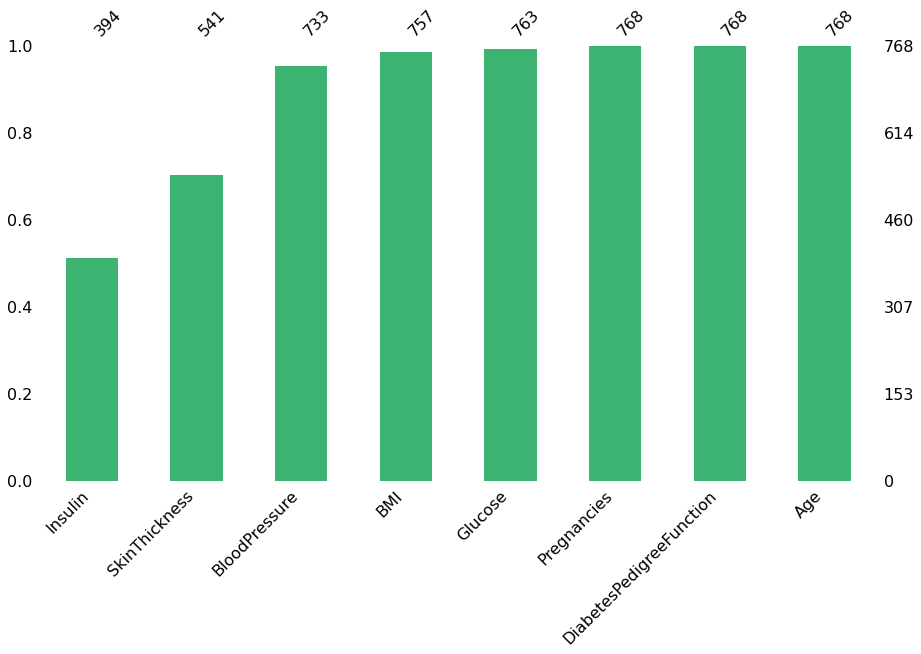

In [7]:
msno.bar(x_data, figsize=(15,8), sort='ascending', color='MediumSeaGreen')

Distribuição de frequência das variáveis

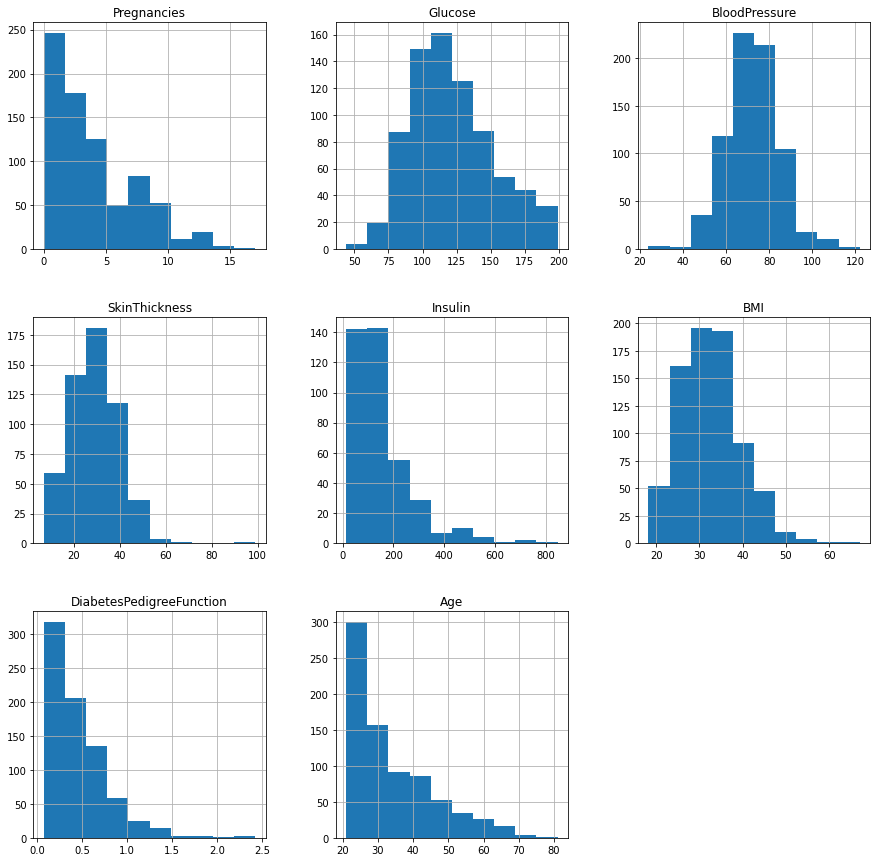

In [8]:
x_data.hist(figsize=(15,15))
plt.show()

Irei preencher os valores ausentes atráves de uma estimativa linear

In [9]:
x_data['Insulin'] = x_data['Insulin'].interpolate(limit_direction='both', axis=0)
x_data['Glucose'] = x_data['Glucose'].interpolate(limit_direction='forward', axis=0)
x_data['BloodPressure'] = x_data['BloodPressure'].interpolate(limit_direction='forward', axis=0)
x_data['SkinThickness'] = x_data['SkinThickness'].interpolate(limit_direction='forward', axis=0)
x_data['BMI'] = x_data['BMI'].interpolate(limit_direction='forward', axis=0)

Distribuição de frequência das variáveis após o preenchimento

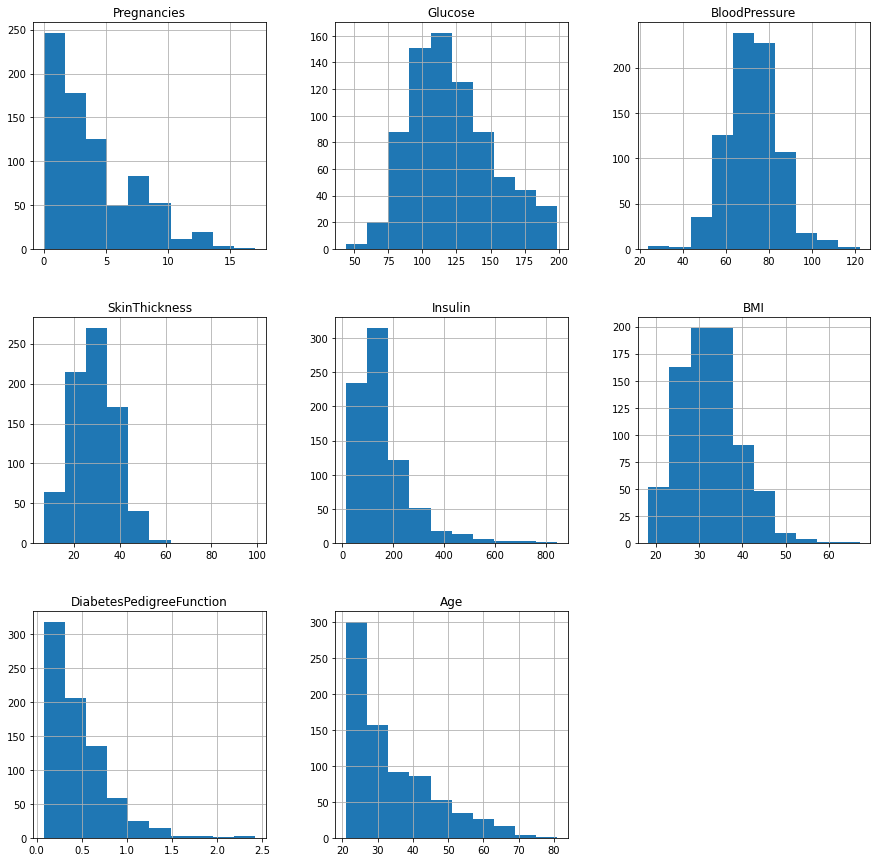

In [10]:
x_data.hist(figsize=(15,15))
plt.show()

aqui irei padronizar as variáveis

In [11]:
padronizador = StandardScaler()
padronizador.fit(x_data)
x_padrao = padronizador.transform(x_data)

criar um dataframe expecifico para plotagem

In [12]:
x_padrao = pd.DataFrame(x_padrao, columns=x_data.keys())
dados = pd.concat([y_data, x_padrao], axis=1)
dados_plot = pd.melt(dados, id_vars='Outcome', var_name='variaveis', value_name='valores')
dados_plot

,Outcome,variaveis,valores
0,1,Pregnancies,0.639947
1,0,Pregnancies,-0.844885
2,1,Pregnancies,1.233880
3,0,Pregnancies,-0.844885
4,1,Pregnancies,-1.141852
...,...,...,...
6139,0,Age,2.532136
6140,0,Age,-0.531023
6141,0,Age,-0.275760
6142,1,Age,1.170732


In [13]:
sns.set_style('darkgrid')

Distribuição de frequência

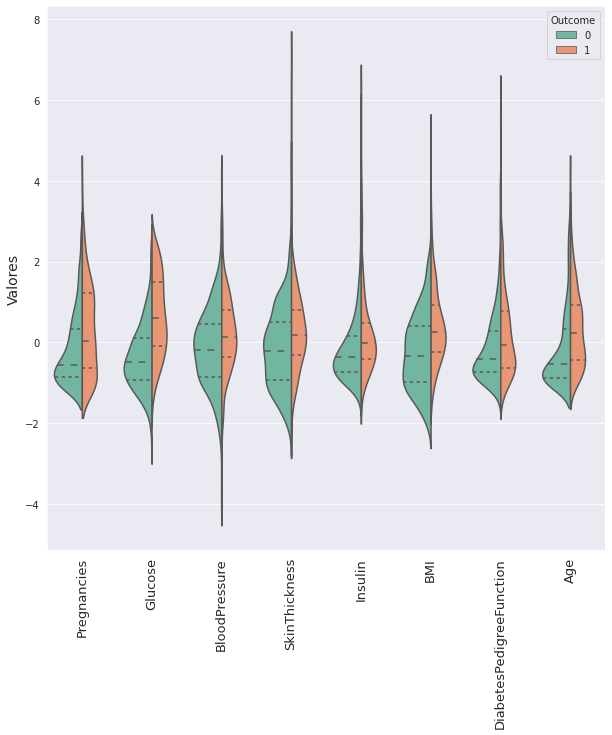

In [14]:
plt.figure(figsize=(10,10))
sns.violinplot(x='variaveis', y='valores', hue='Outcome',
                split=True, palette='Set2', scale='count', inner='quartile', data=dados_plot)
plt.xticks(rotation=90, fontsize=13)
plt.ylabel('Valores', fontsize=14)
plt.xlabel(None)
plt.show()

Através do gráfico posso observar que algumas variáveis podem não contribuir muito para a classificação, são elas:

*   BlodPressure
*   SkinThickness
*   DiabetesPedigreeFunction

In [15]:
x_data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129418,0.196219,0.085915,0.113370,0.021769,-0.033523,0.544341
Glucose,0.129418,1.000000,0.216927,0.183719,0.360812,0.231684,0.138814,0.268057
BloodPressure,0.196219,0.216927,1.000000,0.175081,0.050929,0.273978,-0.005157,0.318358
SkinThickness,0.085915,0.183719,0.175081,1.000000,0.138724,0.494883,0.103014,0.130788
Insulin,0.113370,0.360812,0.050929,0.138724,1.000000,0.137507,0.099506,0.160328
BMI,0.021769,0.231684,0.273978,0.494883,0.137507,1.000000,0.157147,0.025975
DiabetesPedigreeFunction,-0.033523,0.138814,-0.005157,0.103014,0.099506,0.157147,1.000000,0.033561
Age,0.544341,0.268057,0.318358,0.130788,0.160328,0.025975,0.033561,1.000000


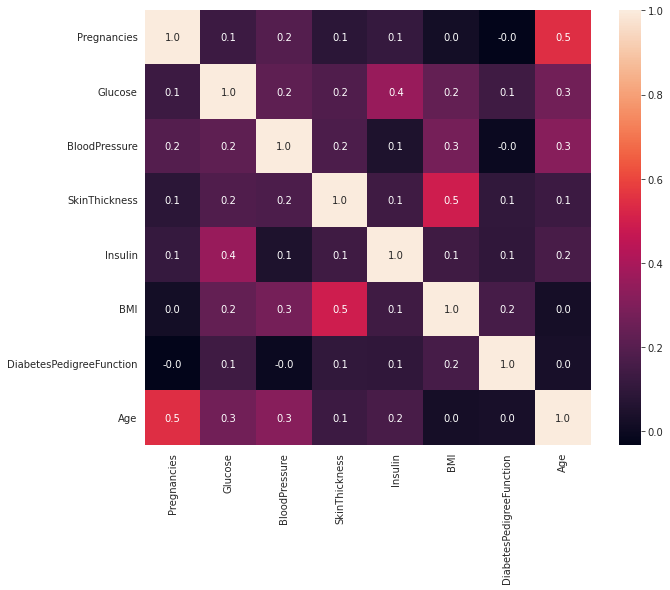

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(x_data.corr(), annot=True, fmt='.1f')

Nenhuma variável preditora tem um correlacionamento alto com outra preditora. preditoras com alto correlacionamento podem ocasionar multicolinearidade.

Obtendo previsões

In [70]:
def metrics(real, previ, previ_proba):
  print(f'metrics predict:')
  print(f'accuracy: {accuracy_score(real, previ)}')
  print(f'precision: {precision_score(real, previ)}')
  print(f'recall: {recall_score(real, previ)}')

  matriz_conf = confusion_matrix(real, previ)
  sns.heatmap(matriz_conf, annot=True, fmt='d')
  plt.ylabel('Real', fontsize=14)
  plt.xlabel('Previsto', fontsize=14)
  fpr, tpr, _ = roc_curve(real, previ_proba)
  auc = roc_auc_score(real, previ_proba)
  plt.figure(figsize=(6,4))
  sns.lineplot(x=fpr, y=tpr, label='AUC=' + str(auc))
  plt.title('ROC')
  plt.legend(loc=4)

In [71]:
def fit_and_predict(modelo, dados, labels):
  x_train, x_test, y_train, y_test = train_test_split(dados, labels, test_size=0.3,
                                                      random_state=2022, stratify=labels)
  
  scaler = StandardScaler()
  pipeline = Pipeline([('Transformação', scaler), ('estimador', modelo)])

  score = cross_val_score(pipeline, x_train, y_train, cv=5)
  print('Cross validade metrics:')
  print(f'score mean: {score.mean()}\nscore std: {score.std()}\n')

  scaler.fit(x_train)
  x_train = padronizador.transform(x_train)
  x_test = padronizador.transform(x_test)

  modelo.fit(x_train, y_train)
  pred = modelo.predict(x_test)
  pred_proba = modelo.predict_proba(x_test)[::,1]
  metrics(y_test, pred, pred_proba)


Criando um base line

metrics predict:
accuracy: 0.5411255411255411
precision: 0.3493975903614458
recall: 0.35802469135802467


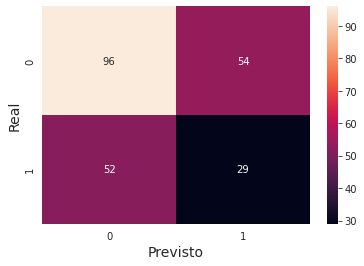

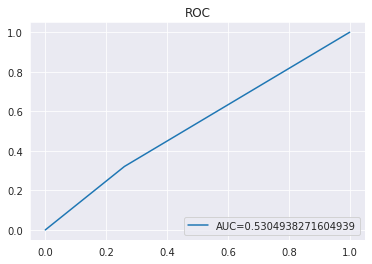

In [73]:
x_train, x_test, y_train,  y_test = train_test_split(x_padrao, y_data, test_size=0.3,
                                                     stratify=y_data, random_state=2022)
dummy = DummyClassifier(strategy = 'stratified')
dummy.fit(x_train, y_train)
dummy_predict = dummy.predict(x_test)
dummy_predict_proba = dummy.predict_proba(x_test)[::,1]
metrics(y_test, dummy_predict, dummy_predict_proba)

testando modelos de classificação

Cross validade metrics:
score mean: 0.7617168570439599
score std: 0.019041080292894325

metrics predict:
accuracy: 0.7575757575757576
precision: 0.6712328767123288
recall: 0.6049382716049383


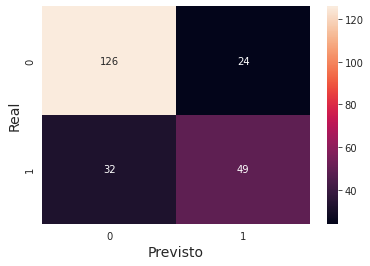

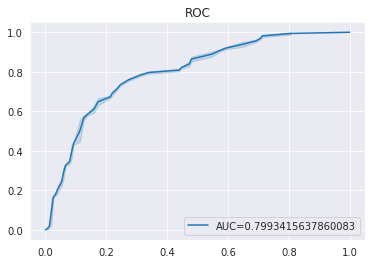

In [74]:
logreg = LogisticRegression()
fit_and_predict(logreg, x_data, y_data)

Cross validade metrics:
score mean: 0.7338352371062651
score std: 0.036951389536867205

metrics predict:
accuracy: 0.6363636363636364
precision: 0.47761194029850745
recall: 0.3950617283950617


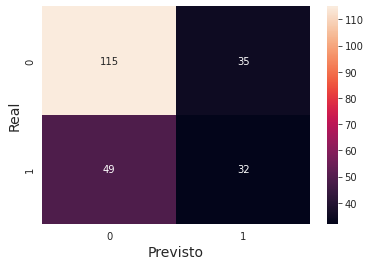

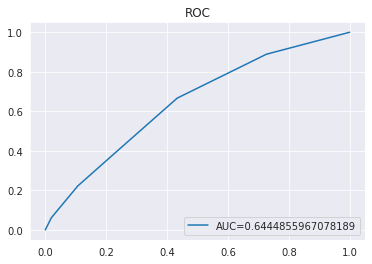

In [75]:
knn = KNeighborsClassifier()
fit_and_predict(knn, x_padrao, y_data)

### Redução de dimensionalidade

#### select kbest

In [49]:
x_train, x_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.3,
                                                     stratify=y_data, random_state=2022)

In [50]:
kmelhores = SelectKBest(chi2, k=5)
kmelhores.fit(x_train, y_train)
x_train_kbest = kmelhores.transform(x_train)
x_test_kbest = kmelhores.transform(x_test)

após a redução de dimensionalidade apenas 5 variáveis ficaram, são elas:

In [51]:
x_train.columns[kmelhores.get_support()]

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age'], dtype='object')

testando modelos de classificação

metrics predict:
accuracy: 0.7619047619047619
precision: 0.6756756756756757
recall: 0.6172839506172839


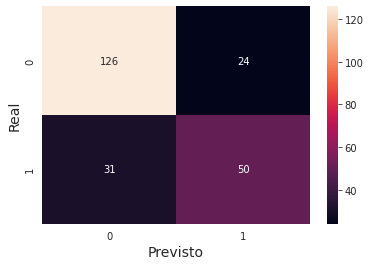

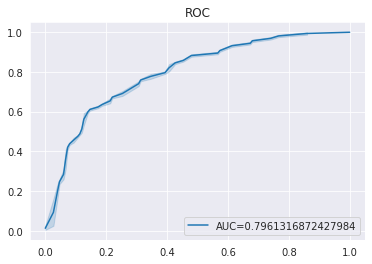

In [76]:
logreg = LogisticRegression()
logreg.fit(x_train_kbest, y_train)
predict = logreg.predict(x_test_kbest)
predict_proba = logreg.predict_proba(x_test_kbest)[:,1]
metrics(y_test, predict, predict_proba)

metrics predict:
accuracy: 0.7316017316017316
precision: 0.6144578313253012
recall: 0.6296296296296297


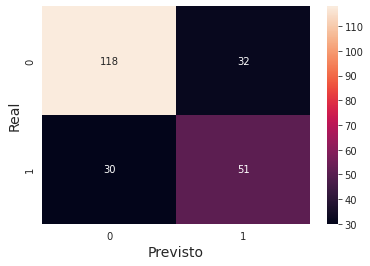

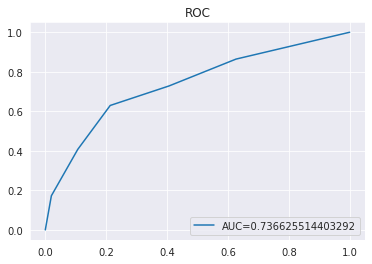

In [77]:
knn = KNeighborsClassifier()
knn.fit(x_train_kbest, y_train)
predict = knn.predict(x_test_kbest)
predict_proba = knn.predict_proba(x_test_kbest)[:,1]
metrics(y_test, predict, predict_proba)